In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse

# Load the data
train_data = pd.read_csv("tmp/filtered_data.csv")
test_data = pd.read_parquet("data/test_data.parquet")

# Convert expiry to datetime if it's not already
if train_data["expiry"].dtype != "datetime64[ns]":
    train_data["expiry"] = pd.to_datetime(train_data["expiry"])

# Get the target expiry date
target_date = pd.Timestamp("2025-05-08").date()


In [2]:
data_path = "data"
output_path = "output/"
temp_path = "tmp/"

sample_submission = pd.read_csv(f"{data_path}/sample_submission.csv")
submission_cols = sample_submission.columns.tolist()

In [3]:
# Filter rows with the specified expiry date
expiry_filter = train_data['expiry'].dt.date == target_date
target_rows = train_data[expiry_filter]

# Get indices of rows to be used for validation (50% of the rows with target expiry)
validation_indices = target_rows.sample(frac=0.5, random_state=43).index

# Create validation set
val_data = train_data.loc[validation_indices].copy()

# Remove validation data from training set
train_data = train_data.drop(validation_indices)

# Print shapes to confirm
print(f"Original training data shape: {len(train_data) + len(val_data)}")
print(f"New training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Original training data shape: 178340
New training data shape: (138752, 97)
Validation data shape: (39588, 97)
Test data shape: (12065, 96)


## Setting 32 columns to nan randomly in each row

In [16]:
import os
if os.path.exists(f"{temp_path}/sample_val.csv") and os.path.exists(
    f"{temp_path}/val_Y.csv"
):
    # If the sample files already exist, load them
    sample_val = pd.read_csv(f"{temp_path}/sample_val.csv")
    val_Y = pd.read_csv(f"{temp_path}/val_Y.csv")
    print("Loaded existing sample_val and val_Y.")
else:
    # Create a copy of val_data to avoid modifying the original
    sample_val = val_data.copy()

    # Get the call and put columns separately
    call_cols = [col for col in val_data.columns if col.startswith("call")]
    put_cols = [col for col in val_data.columns if col.startswith("put")]

    # For each row, randomly select 16 call columns and 16 put columns to set to NaN
    for idx in sample_val.index:
        # Randomly select 16 call columns for this row
        nan_call_cols = np.random.choice(call_cols, size=16, replace=False)

        # Randomly select 16 put columns for this row
        nan_put_cols = np.random.choice(put_cols, size=16, replace=False)

        # Set these columns to NaN for this row
        sample_val.loc[idx, nan_call_cols] = np.nan
        sample_val.loc[idx, nan_put_cols] = np.nan

    # Create val_Y from the original validation data, containing only the target columns
    val_Y = val_data[val_data.columns]
    sample_val.to_csv(f"{temp_path}/sample_val.csv", index=False)
    val_Y.to_csv(f"{temp_path}/val_Y.csv", index=False)

In [17]:
sample_val

,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
158881,1746590742000000000,24433.0,2025-05-08,NaN,NaN,NaN,NaN,NaN,NaN,0.256415,...,-0.022656,0.006262,2.553592e+06,-0.001931,2.372125,0.068108,-1.522534e+06,-3.048516e+06,1.254699e+06,-0.000000e+00
117518,1746176782000000000,24285.5,2025-05-08,0.206319,0.196580,0.187751,0.178467,0.170073,0.161772,0.154975,...,0.003836,-0.004734,6.693594e+05,0.010055,1.315715,0.030237,5.235704e+04,-8.124241e+06,1.313372e+06,-1.000000e-06
155403,1746520665000000000,24387.5,2025-05-08,0.288416,NaN,0.245484,NaN,NaN,0.173109,NaN,...,0.001037,0.003309,2.847738e+06,0.008796,0.648142,0.041674,3.459928e+05,-2.764208e+07,2.203250e+06,0.000000e+00
159498,1746591359000000000,24384.6,2025-05-08,0.426385,NaN,NaN,NaN,0.309727,NaN,0.242813,...,0.035097,-0.030470,-3.629051e+06,0.146150,-8.941554,1.278703,6.211531e+06,7.623811e+06,-5.587995e+05,3.208558e+06
106693,1746165957000000000,24329.3,2025-05-08,0.211074,0.203584,NaN,NaN,0.181550,0.173841,NaN,...,0.001900,0.002318,-1.051215e+06,0.026776,0.242156,0.025405,2.716713e+06,-3.698245e+06,-0.000000e+00,-0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150469,1746515731000000000,24393.6,2025-05-08,0.287421,0.266833,NaN,NaN,0.199508,NaN,NaN,...,-0.008578,-0.004349,7.608529e+05,0.022286,0.276633,-0.049681,-3.766206e+05,3.310812e+06,0.000000e+00,0.000000e+00
178012,1746609873000000000,24362.1,2025-05-08,0.424743,0.393179,NaN,0.329185,NaN,0.255666,0.216435,...,0.006081,-0.001241,-5.956005e+06,-0.053984,-2.637237,0.118681,-7.248843e+05,-4.210857e+06,-3.790669e+06,0.000000e+00
114201,1746173465000000000,24415.4,2025-05-08,0.216450,NaN,0.197977,NaN,NaN,NaN,NaN,...,0.016044,0.013809,-1.940570e+05,-0.009913,1.074973,0.016054,-3.876233e+05,4.172262e+06,0.000000e+00,1.000000e-06
133136,1746431799000000000,24450.5,2025-05-08,0.255138,NaN,NaN,0.207044,0.190411,NaN,NaN,...,-0.008472,0.003098,3.785463e+05,0.001317,0.374664,0.009704,-6.879767e+06,-6.470817e+06,0.000000e+00,0.000000e+00


## Quadratic Regression

In [5]:
iv_cols = [col for col in train_data.columns if col.startswith("call") or col.startswith("put")]

In [44]:
from tqdm import tqdm

# Extract strike prices from column names
call_strike_prices = np.array([float(col.split('_')[-1]) for col in train_data.columns if col.startswith('call')])
put_strike_prices = np.array([float(col.split('_')[-1]) for col in train_data.columns if col.startswith('put')])

# Initialize dataframe to store predictions
coeffs = pd.DataFrame(index=train_data.index, columns=("call_coeffs", "put_coeffs"))
preds = pd.DataFrame(index=train_data.index, columns=iv_cols)
# Function to perform quadratic regression for a single row
def quad_regression_predict(row, strike_prices, option_type):
    # Get column names for this option type
    cols = [col for col in iv_cols if col.startswith(option_type)]

    # Get non-NaN values and their corresponding strike prices
    valid_mask = ~row[cols].isna()
    valid_cols = np.array(cols)[valid_mask]

    if len(valid_cols) < 3:  # Need at least 3 points for quadratic regression
        return None

    y_vals = row[valid_cols].values.astype(np.float64)
    x_vals = np.array([float(col.split("_")[-1]) for col in valid_cols])
    # Perform quadratic regression
    coeffs = np.polyfit(x_vals, y_vals, 2)
    poly = np.poly1d(coeffs)

    # Predict for all strike prices of this option type
    all_strikes = strike_prices
    predictions = pd.Series(
        poly(all_strikes),
        index=[f"{option_type}_iv_{int(strike)}" for strike in all_strikes],
    )
    # predictions[valid_cols] = row[valid_cols].astype(np.float64)  # Keep original values for known strikes
    return (predictions, coeffs)

# # Apply regression for each row
# for idx in tqdm(train_data.index, desc="Fitting quadratic regression"):
#   # Process call options
#   (call_predictions, call_coeffs) = quad_regression_predict(train_data.loc[idx], call_strike_prices, 'call')
#   if call_predictions is not None:
#     coeffs.loc[idx, 'call_coeffs'] = call_coeffs
#     preds.loc[idx, call_predictions.index] = call_predictions

#   # Process put options
#   (put_predictions, put_coeffs) = quad_regression_predict(train_data.loc[idx], put_strike_prices, 'put')
#   if put_predictions is not None:
#     coeffs.loc[idx, 'put_coeffs'] = put_coeffs
#     preds.loc[idx, put_predictions.index] = put_predictions

coeffs = pd.read_csv("tmp/coeffs.csv")
preds = pd.read_csv("tmp/preds.csv")

In [43]:
coeffs.call_coeffs[0]

'[ 8.57723671e-08 -4.15742043e-03  5.05390215e+01]'

In [45]:
from ast import literal_eval
coeffs.call_coeffs = coeffs.call_coeffs.str.replace("  ", ',')
coeffs.call_coeffs = coeffs.call_coeffs.str.replace(" ", ",")
coeffs.call_coeffs = coeffs.call_coeffs.str.replace("[,", "[")

coeffs.call_coeffs = coeffs.call_coeffs.apply(literal_eval)
# literal_eval(coeffs.loc[0, 'call_coeffs'])

In [22]:
coeffs.call_coeffs[0]

['[', '8.57723671e-08', '-4.15742043e-03', '', '5.05390215e+01]']

In [81]:
preds

,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,...,put_iv_24100,put_iv_24200,put_iv_24300,put_iv_24400,put_iv_24500,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000
0,0.207431,0.195677,0.185638,0.177315,0.170707,0.165815,0.162638,0.161176,0.16143,0.1634,...,0.165786,0.162956,0.161903,0.162627,0.165129,0.169409,0.175466,0.183301,0.192913,0.204303
1,0.207128,0.194297,0.18322,0.173899,0.166331,0.160519,0.156461,0.154157,0.153609,0.154815,...,0.161949,0.158054,0.155866,0.155385,0.15661,0.159542,0.164181,0.170527,0.178579,0.188338
2,0.192485,0.180754,0.170763,0.16251,0.155996,0.15122,0.148183,0.146885,0.147326,0.149505,...,0.151703,0.149297,0.148713,0.149952,0.153013,0.157897,0.164603,0.173132,0.183484,0.195657
3,0.189232,0.177929,0.168338,0.160457,0.154287,0.149829,0.147081,0.146044,0.146718,0.149104,...,0.151178,0.148692,0.14802,0.149164,0.152122,0.156896,0.163485,0.171889,0.182108,0.194143
4,0.190104,0.178775,0.16915,0.16123,0.155014,0.150502,0.147694,0.14659,0.147191,0.149496,...,0.152446,0.149664,0.148659,0.14943,0.151977,0.1563,0.162399,0.170275,0.179926,0.191354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178331,0.411668,0.372154,0.336338,0.304219,0.275797,0.251072,0.230045,0.212716,0.199084,0.189149,...,0.252142,0.23485,0.218953,0.204452,0.191346,0.179637,0.169322,0.160404,0.152881,0.146753
178332,0.410203,0.370891,0.335262,0.303318,0.275058,0.250482,0.229591,0.212383,0.198861,0.189022,...,0.25217,0.23485,0.218924,0.204391,0.191251,0.179506,0.169154,0.160195,0.15263,0.146459
178334,0.411547,0.372056,0.336261,0.304161,0.275756,0.251048,0.230034,0.212717,0.199094,0.189168,...,0.251967,0.234516,0.218441,0.203741,0.190417,0.178469,0.167896,0.158698,0.150876,0.144429
178336,0.410607,0.371283,0.335643,0.303686,0.275414,0.250824,0.229919,0.212698,0.19916,0.189306,...,0.252035,0.234643,0.218633,0.204007,0.190763,0.178903,0.168426,0.159333,0.151622,0.145295


In [82]:
coeffs.to_csv(f"{temp_path}/coeffs.csv", index=False)

In [83]:
preds.to_csv(f"{temp_path}/preds.csv", index=False)

In [9]:
def plot_iv_vs_strike(index, option_type='both'):
  """
  Plot IV vs strike price for a given index, comparing train_data and predictions
  
  Parameters:
  index: row index to plot
  option_type: 'call', 'put', or 'both'
  """
  
  # Get strike prices
  call_strikes = [float(col.split('_')[-1]) for col in train_data.columns if col.startswith('call_iv')]
  put_strikes = [float(col.split('_')[-1]) for col in train_data.columns if col.startswith('put_iv')]
  
  # Get column names
  call_cols = [col for col in train_data.columns if col.startswith('call_iv')]
  put_cols = [col for col in train_data.columns if col.startswith('put_iv')]
  
  if option_type in ['call', 'both']:
    plt.figure(figsize=(12, 6))
    
    if option_type == 'both':
      plt.subplot(1, 2, 1)
    
    # Plot original data
    original_call_iv = train_data.loc[index, call_cols].values
    plt.plot(call_strikes, original_call_iv, 'bo-', label='Original Data', markersize=6)
    
    # Plot predictions
    pred_call_iv = preds.loc[index, call_cols].values
    plt.plot(call_strikes, pred_call_iv, 'r^-', label='Quadratic Fit', markersize=6)
    
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.title(f'Call Options IV vs Strike - Index {index}')
    plt.legend()
    plt.grid(True, alpha=0.3)
  
  if option_type in ['put', 'both']:
    if option_type == 'both':
      plt.subplot(1, 2, 2)
    else:
      plt.figure(figsize=(10, 6))
    
    # Plot original data
    original_put_iv = train_data.loc[index, put_cols].values
    plt.plot(put_strikes, original_put_iv, 'bo-', label='Original Data', markersize=6)
    
    # Plot predictions
    pred_put_iv = preds.loc[index, put_cols].values
    plt.plot(put_strikes, pred_put_iv, 'r^-', label='Quadratic Fit', markersize=6)
    
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.title(f'Put Options IV vs Strike - Index {index}')
    plt.legend()
    plt.grid(True, alpha=0.3)
  
  plt.tight_layout()
  plt.show()


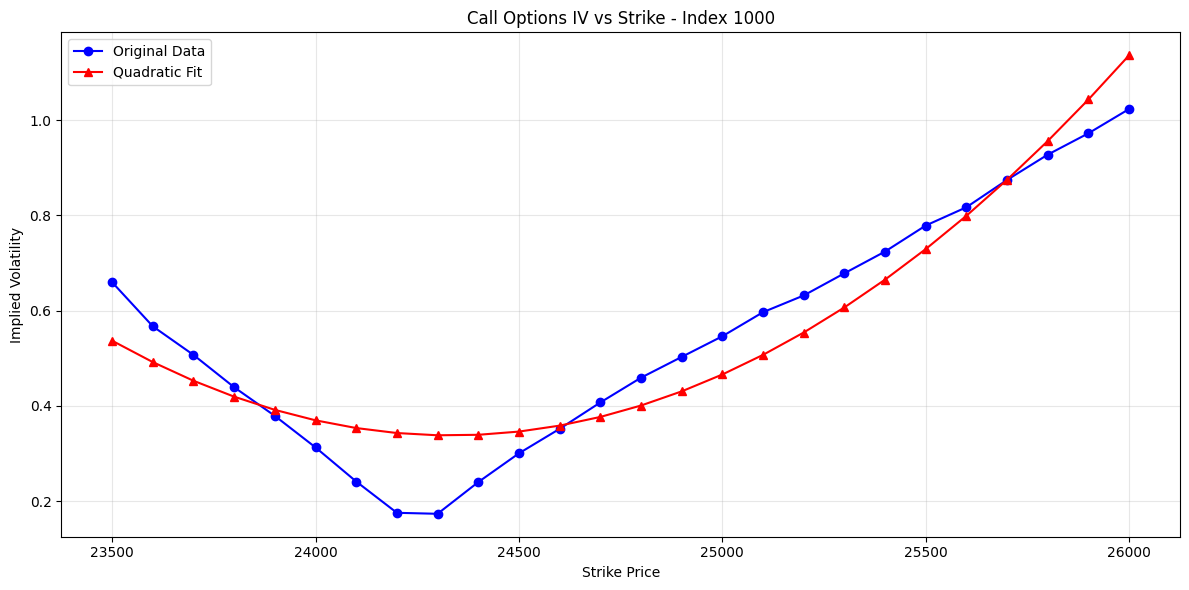

In [10]:
plot_iv_vs_strike(1000, "call")

In [46]:
Y_call= pd.DataFrame(coeffs.call_coeffs.tolist(), index=coeffs.index, columns=["a", "b", "c"])
Y_call

,a,b,c
0,8.577237e-08,-0.004157,50.539021
1,8.773212e-08,-0.004260,51.878687
2,8.693246e-08,-0.004212,51.161809
3,8.554940e-08,-0.004142,50.291049
4,8.521016e-08,-0.004127,50.109927
...,...,...,...
138747,1.848702e-07,-0.009103,112.226440
138748,1.842138e-07,-0.009070,111.813687
138749,1.847769e-07,-0.009098,112.169203
138750,1.841886e-07,-0.009069,111.802800


In [52]:
x_cols = ['underlying'] + [f"X{i}" for i in range(0,42)]
X_call = train_data[x_cols].copy()

In [ ]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_call, Y_call, test_size=0.2, random_state=42)
print(X_train.shape)
# Initialize lists to store RMSE values
rmse_scores = {}
predictions = {}

# Train separate models for a, b, and c
for target in ['a', 'b', 'c']:
  print(f"\nTraining XGBoost model for {target}...")
  
  # Create XGBoost regressor
  model = xgb.XGBRegressor(
    random_state=42
  )
  
  # Train the model
  model.fit(X_train, y_train[target])
  
  # Make predictions
  y_pred = model.predict(X_test)
  predictions[target] = y_pred
  
  # Calculate RMSE
  rmse_score = rmse(y_test[target], y_pred)
  rmse_scores[target] = rmse_score
  
  print(f"RMSE for {target}: {rmse_score:.6f}")
  print(f"Mean value of {target}: {Y_call[target].mean():.6f}")

print(f"\nOverall RMSE scores:")
for target, score in rmse_scores.items():
  print(f"{target}: {score:.6f}")

(111001, 43)

Training XGBoost model for a...
RMSE for a: 0.000000
Mean value of a: 0.000000

Training XGBoost model for b...
RMSE for b: 0.004646
Mean value of b: -0.009932

Training XGBoost model for c...
RMSE for c: 58.007703
Mean value of c: 121.589048

Overall RMSE scores:
a: 0.000000
b: 0.004646
c: 58.007703


Training model for coefficient 'a'...
RMSE for coefficient 'a': 0.000000
Training model for coefficient 'b'...
RMSE for coefficient 'b': 0.004201
Training model for coefficient 'c'...
RMSE for coefficient 'c': 51.106558

Summary of Results:
Coefficient a: RMSE = 0.000000
Coefficient b: RMSE = 0.004201
Coefficient c: RMSE = 51.106558
